In [1]:
# These settings are for the notebook only
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
# Set the path to the root directory of the project
# This should be changed when required
import sys
sys.path.append('../..')

In [22]:
# Import the required modules
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
import copy

# Import the required modules from the magrec package
from magrec.misc.plot import plot_n_components
from magrec.transformation.MagneticFields import MagneticFields   
from magrec.transformation.Bsensor2Mxy import Bsensor2Mxy   
from magrec.transformation.Mxy2Bsensor import Mxy2Bsensor
from magrec.method.CNN import CNN
from magrec.models.UniformMagnetisation import UniformMagnetisation
from magrec.misc.data import Data
from magrec import __datapath__

Applied a high frequency filter, removing all components smaller than 0.03 um


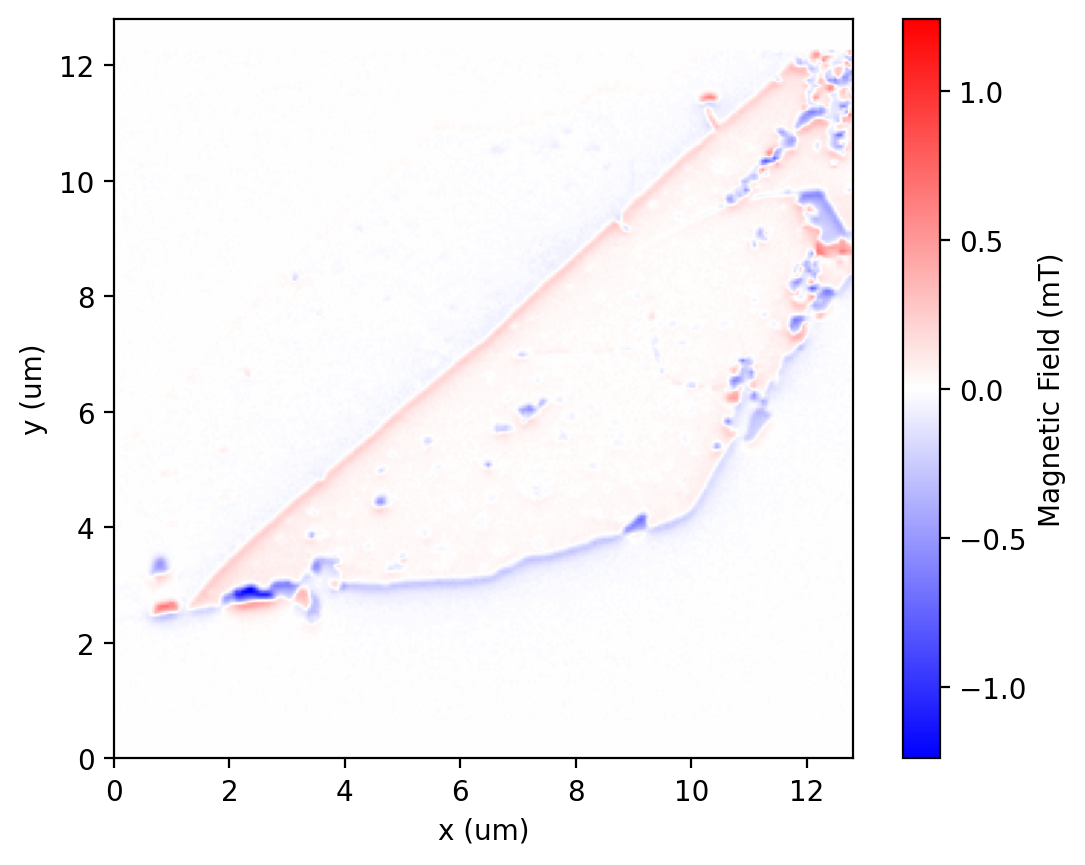

In [4]:
# Load the data from the database
f = open(__datapath__ / "experimental" / "Magnetisation out of plane" / "CrI3_Exp_B_20180525_001.json")
data = json.load(f)

# Extract the data from the json file
BNV = data["ExperimentMagneticField"]['BNV']["Data"]
dx=data['ExperimentMagneticField']['MagnetisationPropagation']['PropStruct']['PixelSizeX'] *1e6 # in μm
dy=data['ExperimentMagneticField']['MagnetisationPropagation']['PropStruct']['PixelSizeX'] *1e6

# Define the sensor parameters
sensor_theta = 56
sensor_phi = data["ExperimentMagneticField"]['BNV']['Phi'] - 92
height = 30e-3 # um
layer_thickness = 0

# initalise the dataset object and load the data
dataset = Data()
dataset.load_data(BNV, dx, dy, height, sensor_theta, sensor_phi, layer_thickness)

# Add spatial filters and perform other actions on the dataset 
dataset.add_hanning_filter(height)
dataset.add_short_wavelength_filter(height)
dataset.remove_DC_background()
dataset.crop_data([0,256,0,256])
dataset.pad_data_to_power_of_two()
dataset.plot_target()

In [5]:
# Display all of the actions that have been performed on the data
dataset.actions

action type  reverseable reverse action  \
0                load_data        False           None   
1           hanning_filter        False           None   
2  short_wavelength_filter        False           None   
3     remove_DC_background        False           None   
4                crop_data        False      crop_data   
5                 pad_data         True      crop_data   

                                         description            parameters  
0                                    loaded the data                  None  
1  Applied a low frequency filter, removing all c...     wavelength = 0.03  
2  Applied a high frequency filter, removing all ...     wavelength = 0.03  
3            Removed the DC background from the data                  None  
4    crop the data with the given region of interest  roi = [0,256,0,256,]  
5  Padded the data to a square image with dimensi...                  None

# Transform Bsensor into Bxyz
Here we take a single B measurement (Bsensor) and transform it into a map of Bxyz. This is an important validation step to identify if the angles that have been used for the senor make sense. Keep in mind that the definitions of array and the plotting of these arrays can change between programing langugues. So double check that these field make sense with the expected source.   

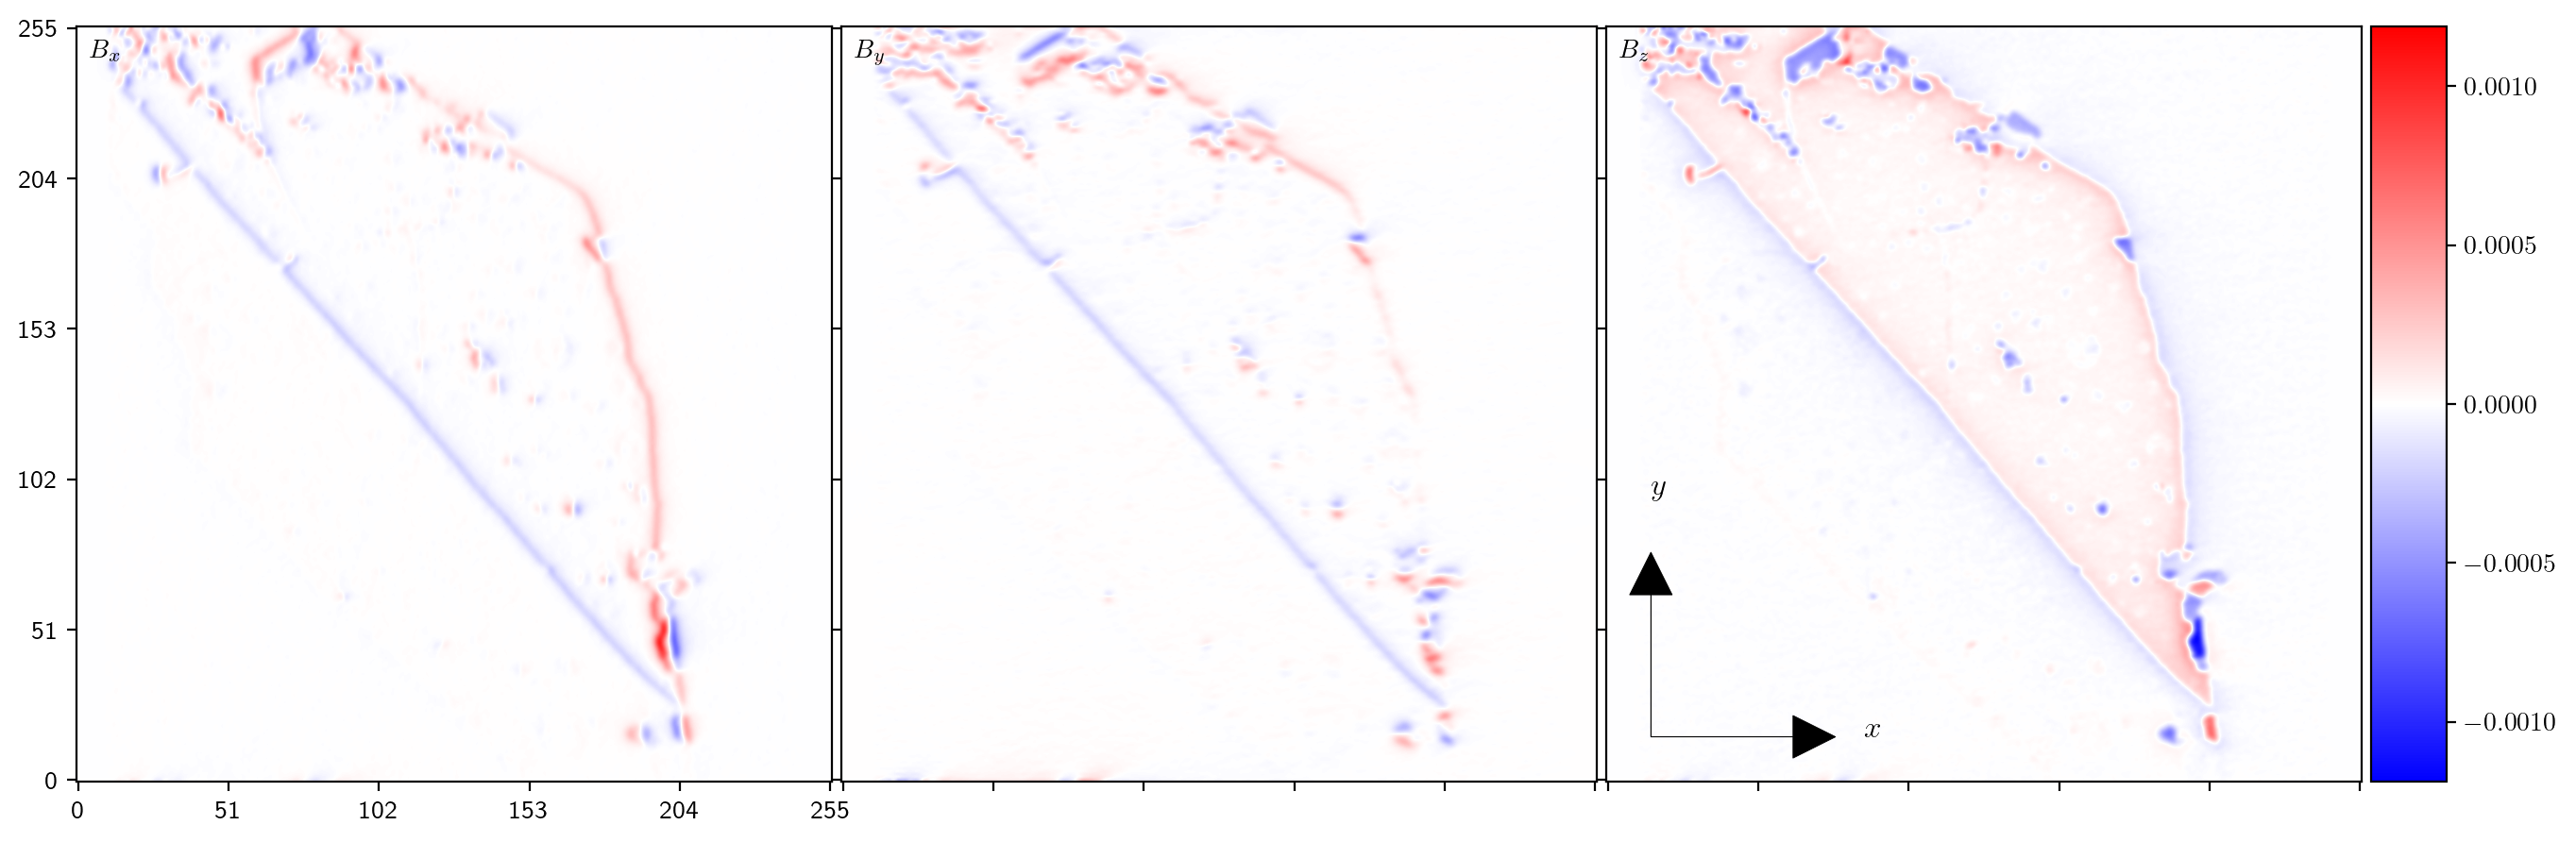

In [6]:
# Set the transformation to be performed on the data
dataset.set_transformer(MagneticFields)
# Perform the transformation
dataset.transform_data()

# Define the Bz data from the bx, by, and bz recontruction
Bx_data = dataset.transformed_target[0,::]
By_data = dataset.transformed_target[1,::]
Bz_data = dataset.transformed_target[2,::]

plot_n_components(dataset.transformed_target, symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$"], cmap="bwr", 
imshow_kwargs={"interpolation": "bicubic"})

# Reconstruction of magnetisation with different approaches

## 1. Fourer reconstruction (Bsensor -> Mz)

Applied a high frequency filter, removing all components smaller than 0.03 um
no input provided, using the dataset target


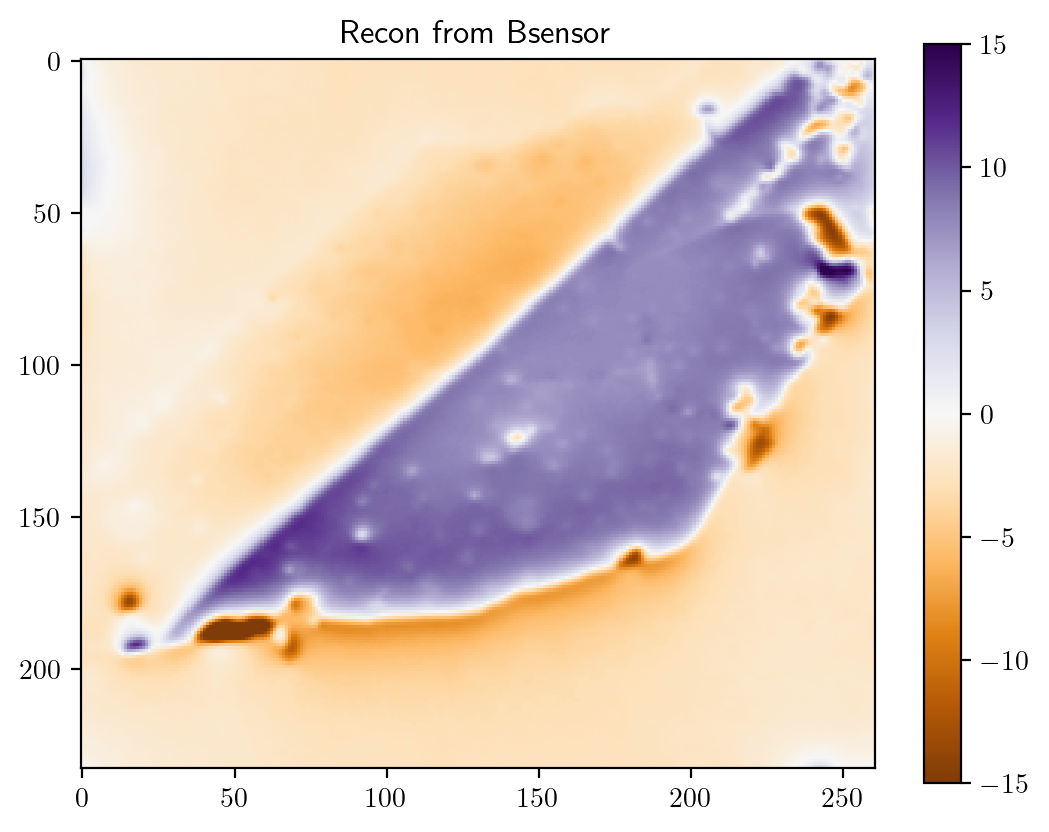

In [7]:
# Define a new dataset object for the reconstruction
Frecon_dataset = Data()
Frecon_dataset.load_data(BNV, dx, dy, height, sensor_theta, sensor_phi, layer_thickness)

# Set the transformation to be performed on the data
Frecon_dataset.set_transformer(Bsensor2Mxy, m_theta = 0, m_phi =0)
# Perform the transformation
Frecon_dataset.transform_data()

# Plot the reconstructed result
plt.figure()
plt.imshow(-1*Frecon_dataset.transformed_target, cmap="PuOr", vmin=-15, vmax = 15)
plt.title("Recon from Bsensor")
plt.colorbar()


## 2. Fourier Reconstruction (Bz -> Mz)

Applied a high frequency filter, removing all components smaller than 0.03 um
no input provided, using the dataset target


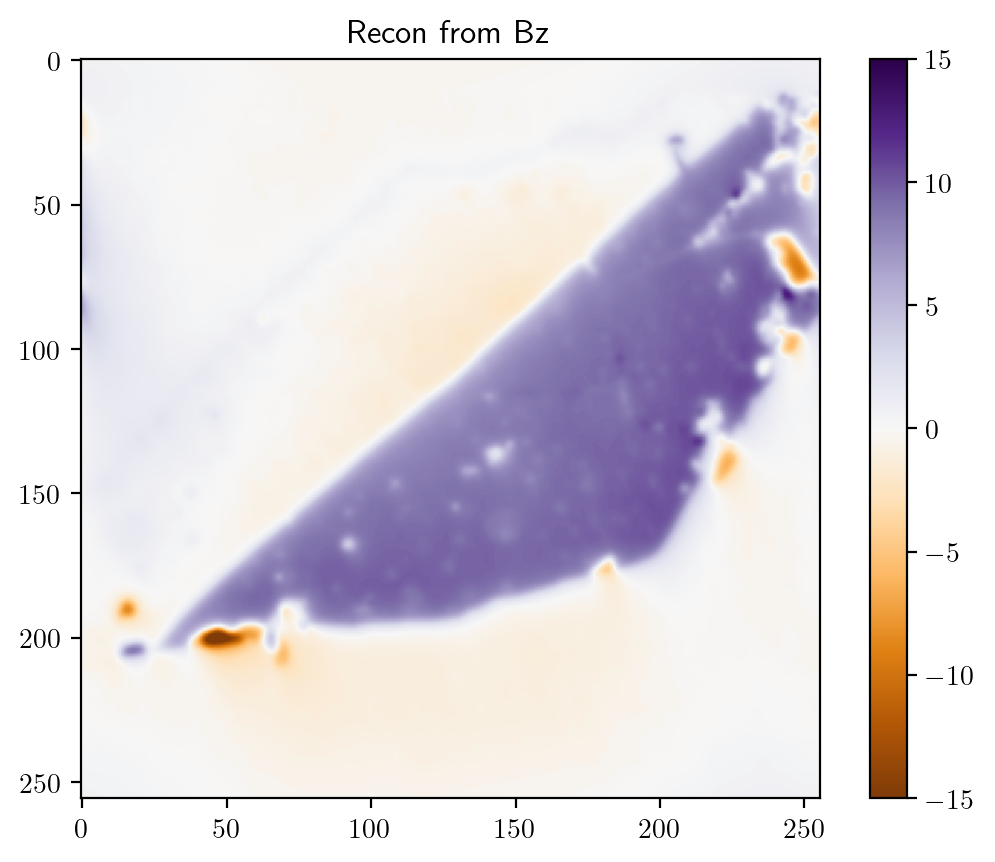

In [14]:
# load a new dataset object
Frecon_bz_dataset = Data()
Frecon_bz_dataset.load_data(Bz_data, 
                            dx = dx, 
                            dy = dy, 
                            height = height, 
                            theta = 0, 
                            phi = 0, 
                            layer_thickness = 0)
# Set the transformation to be performed on the data
Frecon_bz_dataset.set_transformer(Bsensor2Mxy, m_theta = 0, m_phi = 0)
Frecon_bz_dataset.transform_data()

# Plot the reconstructed result
plt.figure()
plt.imshow(-1*Frecon_bz_dataset.transformed_target + 2, cmap="PuOr", vmin=-15, vmax = 15)
plt.title("Recon from Bz")
plt.colorbar()

## 3. Check the inverse transformation (Mz > Bz)

<Figure size 640x480 with 0 Axes>

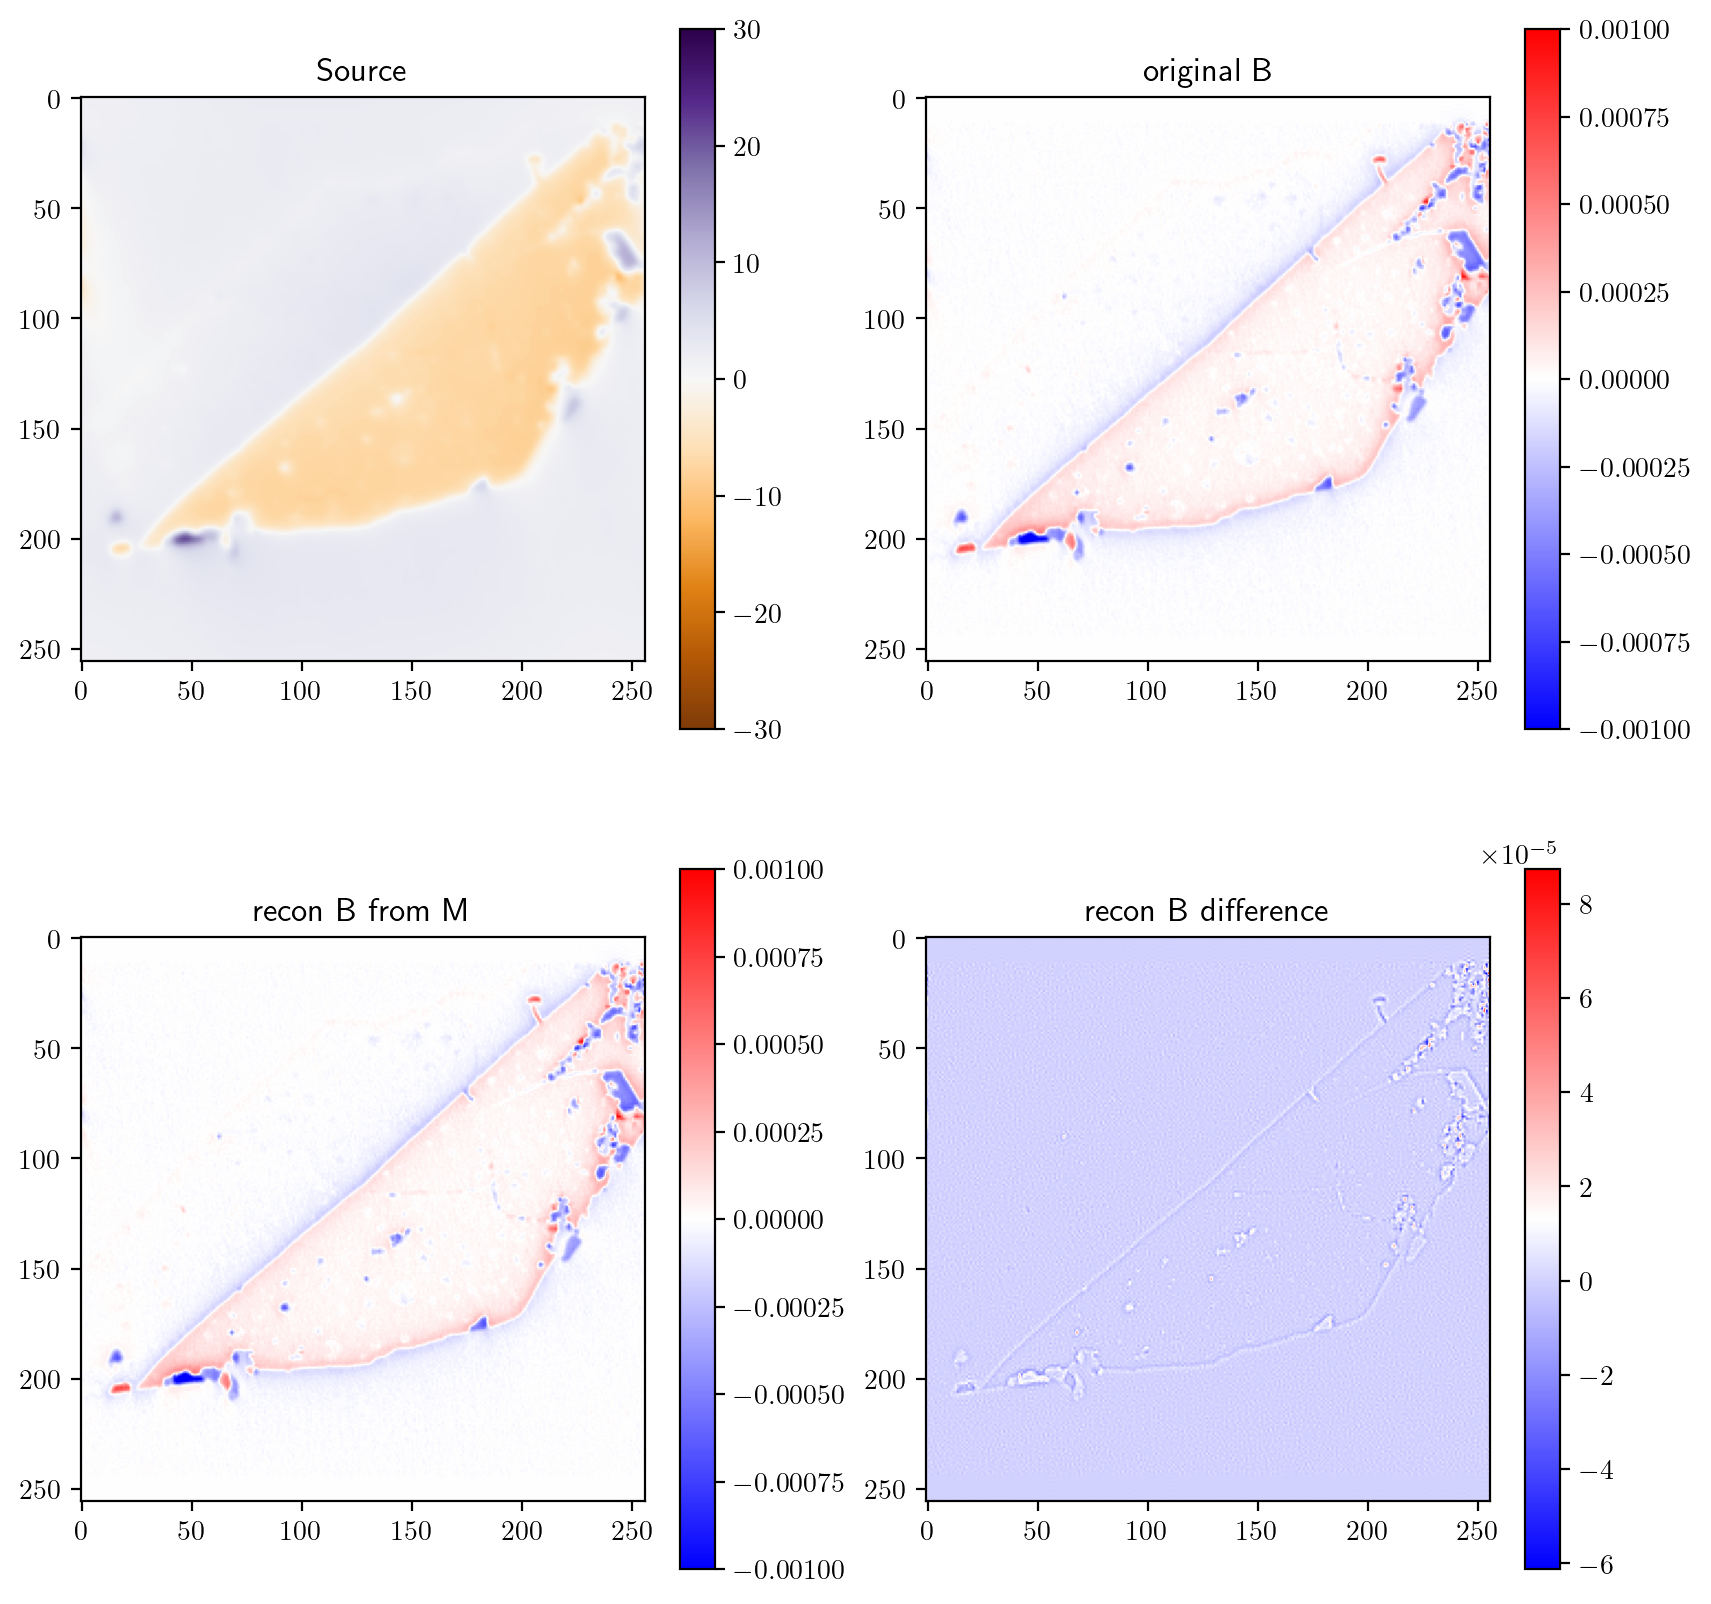

In [19]:
# Define the Bz data from the bxyz recontruction
Mz_data = Frecon_bz_dataset.transformed_target

# load a new dataset object
Frecon_Mz_dataset = Data()
Frecon_Mz_dataset.load_data(Mz_data, 
                            dx = dx, 
                            dy = dy, 
                            height = height, 
                            theta = 0, 
                            phi = 0, 
                            layer_thickness = 0)

# dataset3.target = dataset2.transformed_target
# dataset3.define_sensor_angles(0, 0)
# dataset3.define_height(0.05)

magClass = Mxy2Bsensor(Frecon_Mz_dataset, m_theta = 0, m_phi = 0)

btest = magClass.transform(Mz_data)

plt.figure()
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(Frecon_bz_dataset.transformed_target, cmap="PuOr", vmin=-30, vmax=30)
plt.title("Source")
plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(Frecon_bz_dataset.target, cmap="bwr", vmin=-0.001, vmax=0.001)
plt.title("original B")
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(btest, cmap="bwr", vmin=-0.001, vmax=0.001)
plt.title("recon B from M")
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(Frecon_bz_dataset.target - btest, cmap="bwr")
plt.title("recon B difference")
plt.colorbar()

## 4. Reconstruction with CNN

In [23]:
# make a new dataset object for the reconstruction
NN_recon_data = Data()
NN_recon_data.load_data(Bz_data, 
                        dx = dx, 
                        dy = dy, 
                        height = height, 
                        theta = 0, 
                        phi = 0, 
                        layer_thickness = 0)

# Define the model of the source that will be reconstructed
Model = UniformMagnetisation(NN_recon_data, 
                             loss_type = "MSE", 
                             m_theta = 0, 
                             m_phi = 0,
                             scaling_factor = 1e6,
                             source_weight = None,
                             loss_weight = None, )

# Define the fitting method and pass it the model
FittingMethod = CNN(Model, learning_rate = 0.1)

Number of sources: 1
Number of targets: 1


epoch     1 | loss on last mini-batch:  6.22e+03
epoch    11 | loss on last mini-batch:  6.21e+03
epoch    21 | loss on last mini-batch:  6.18e+03
epoch    31 | loss on last mini-batch:  6.07e+03
epoch    41 | loss on last mini-batch:  5.82e+03
epoch    51 | loss on last mini-batch:  5.36e+03
epoch    61 | loss on last mini-batch:  4.67e+03
epoch    71 | loss on last mini-batch:  3.62e+03
epoch    81 | loss on last mini-batch:  2.24e+03
epoch    91 | loss on last mini-batch:  1.24e+03
epoch   101 | loss on last mini-batch:  8.23e+02
epoch   111 | loss on last mini-batch:  6.94e+02
epoch   121 | loss on last mini-batch:  5.98e+02
epoch   131 | loss on last mini-batch:  5.29e+02
epoch   141 | loss on last mini-batch:  4.81e+02
epoch   151 | loss on last mini-batch:  4.41e+02
epoch   161 | loss on last mini-batch:  4.42e+02
epoch   171 | loss on last mini-batch:  3.85e+02
epoch   181 | loss on last mini-batch:  3.52e+02
epoch   191 | loss on last mini-batch:  3.35e+02


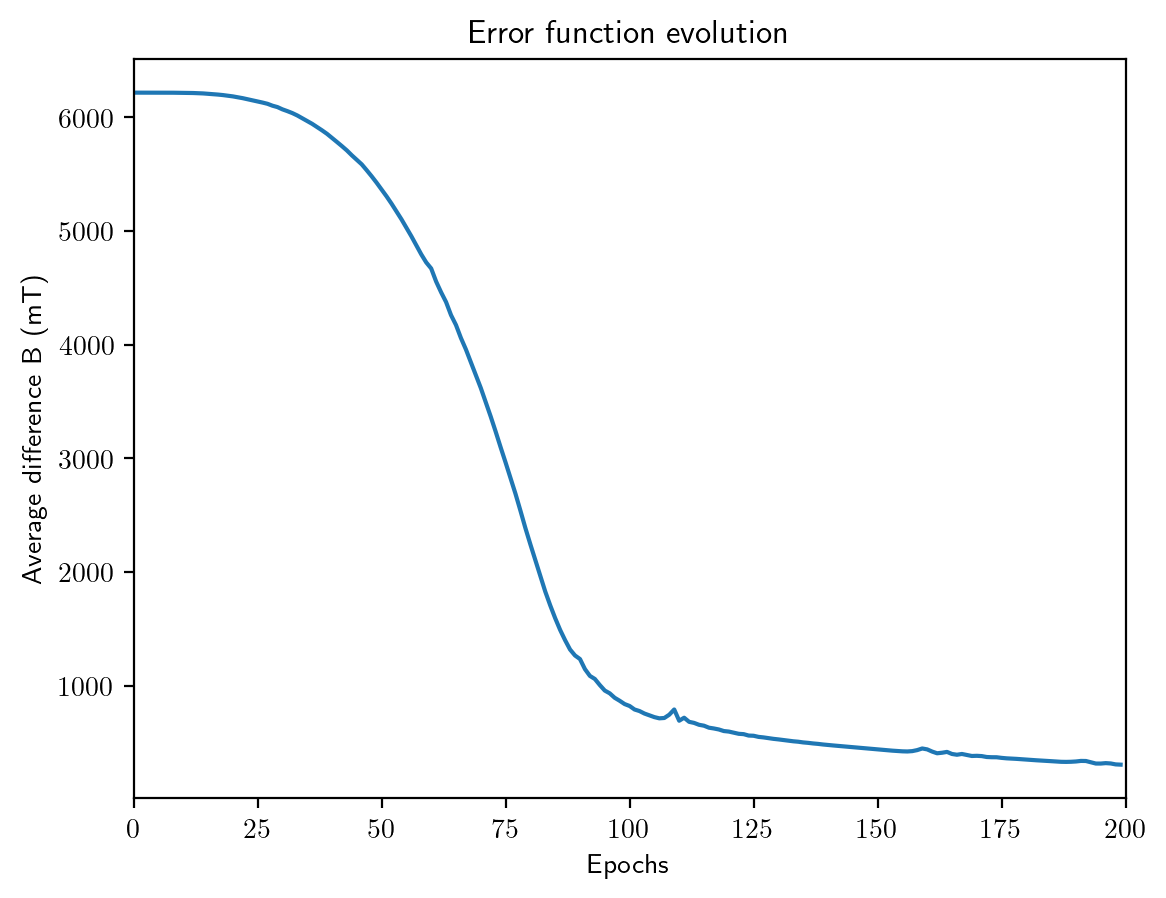

In [24]:
# Perform the fit using the NN
FittingMethod.fit(n_epochs=200)
# Plot the exvolution of the loss function
FittingMethod.plot_loss()

Removed the padding that was applied to the data


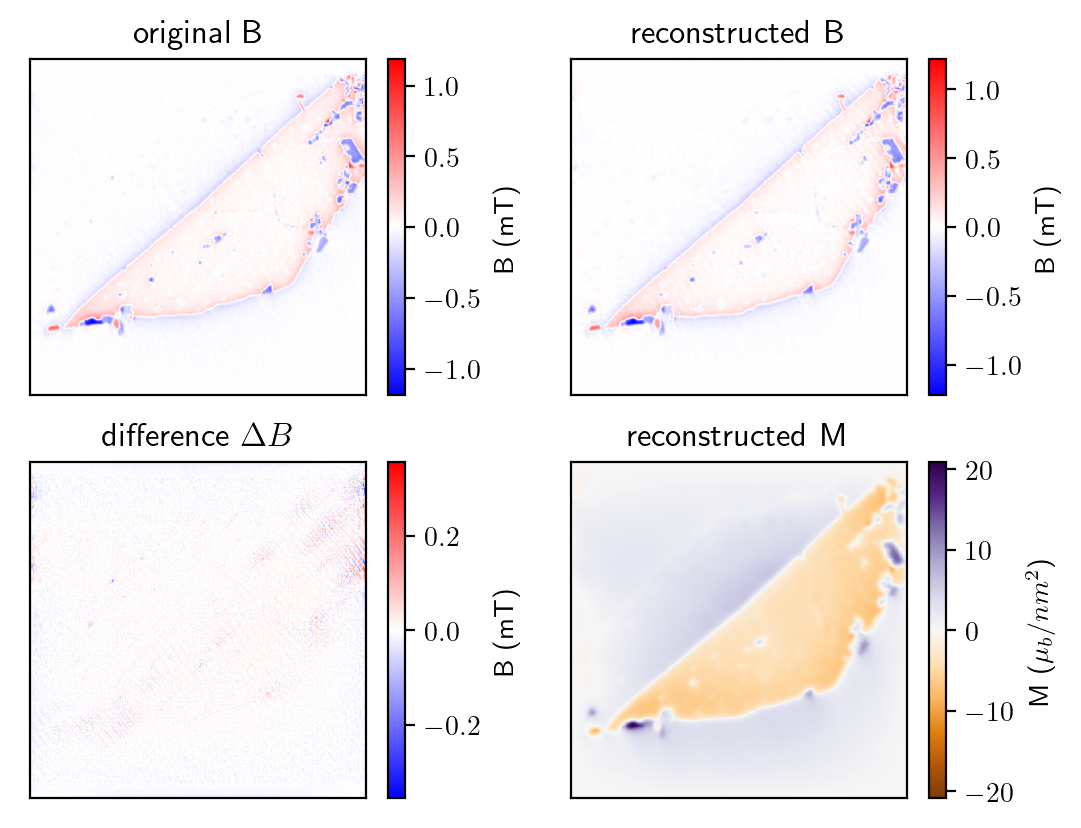

In [25]:
# Plot the results of the reconstruction
FittingMethod.plot_results()

## 5. Reconstruction with CNN and a Source Mask

Number of sources: 1
Number of targets: 1


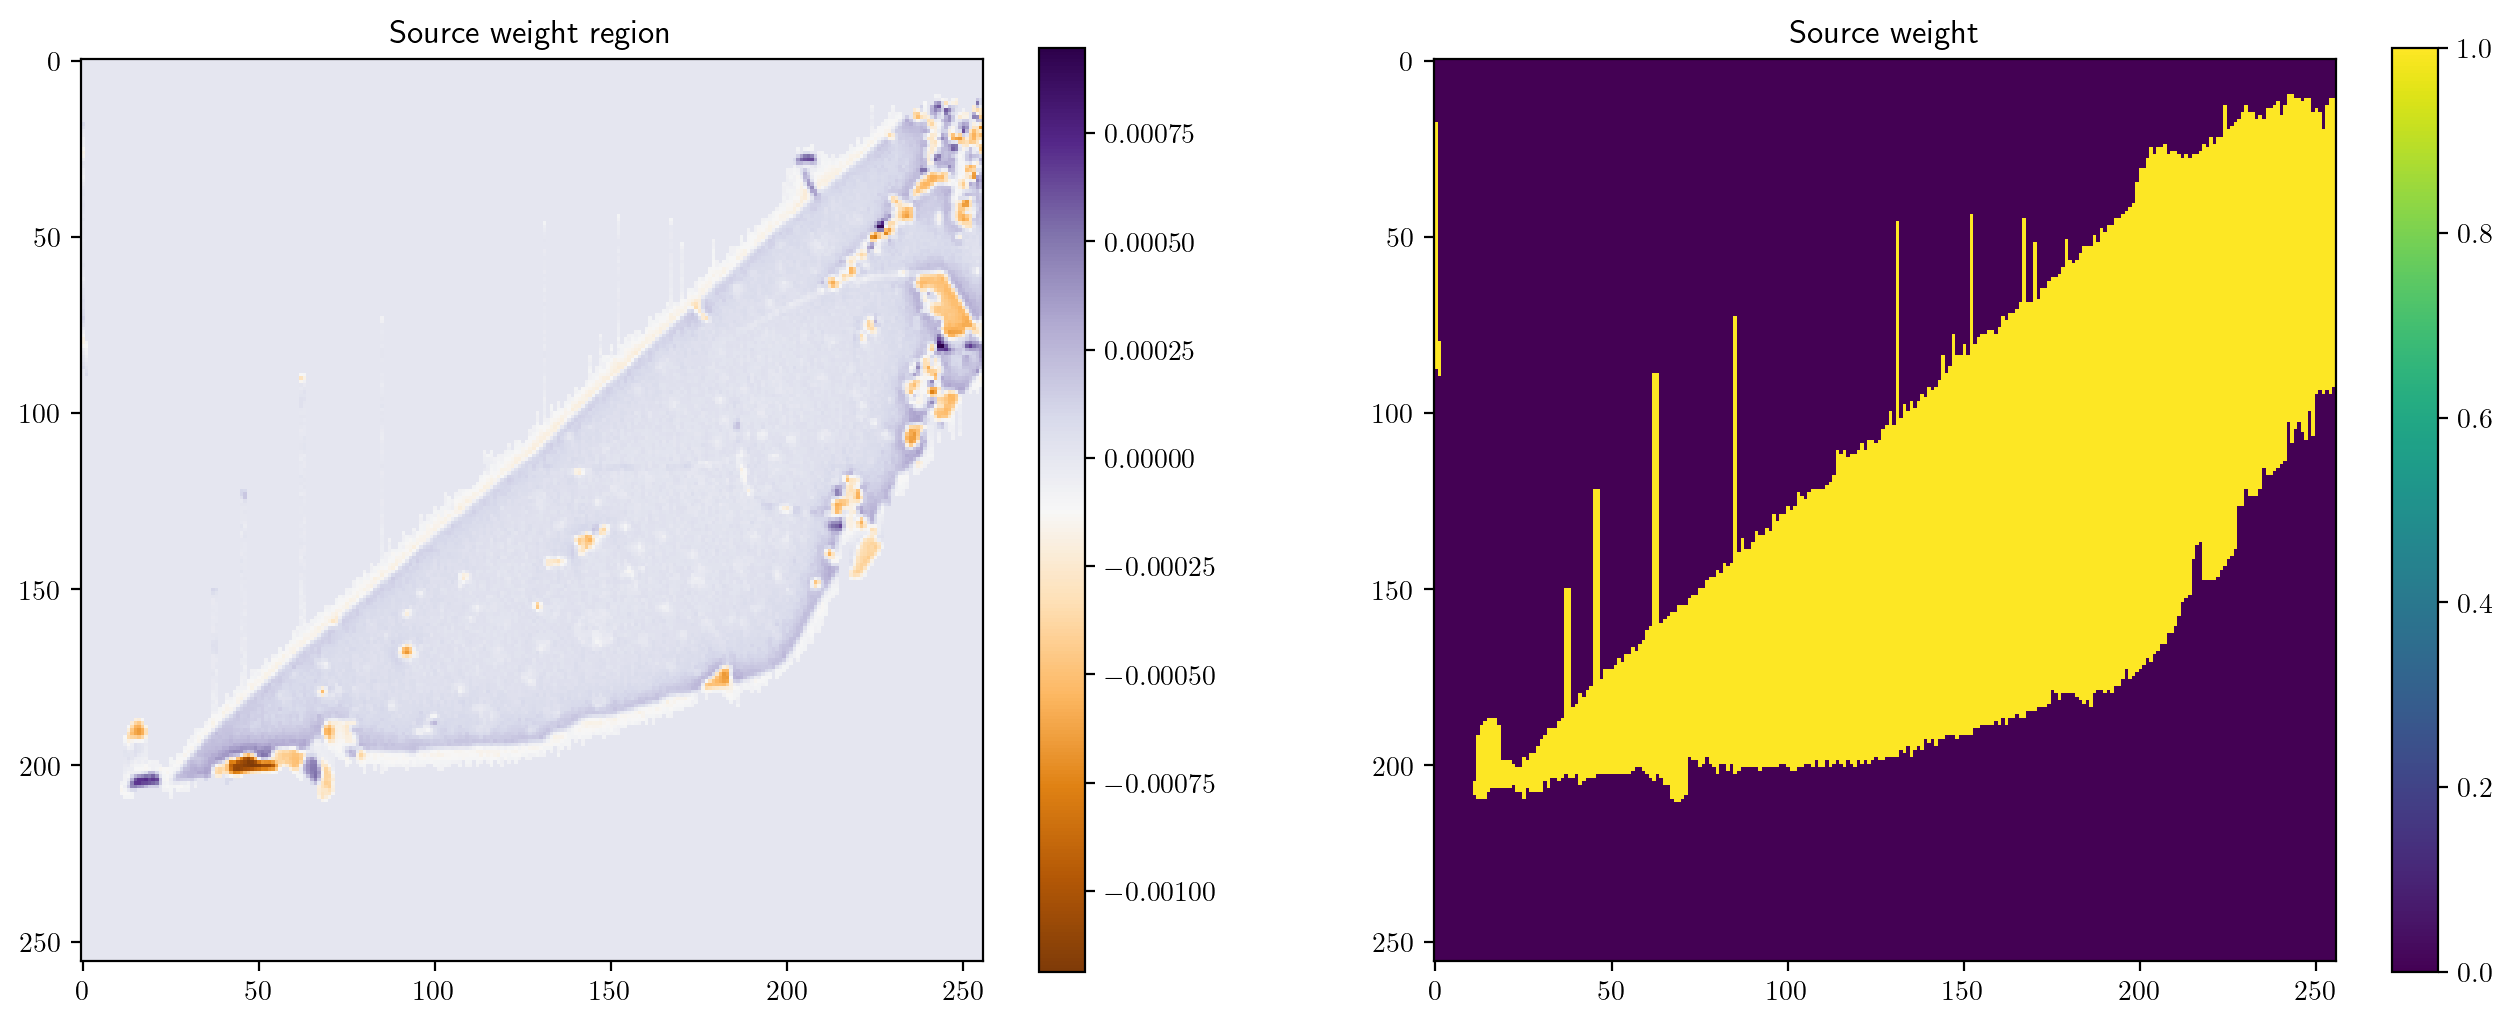

In [34]:
import magrec.image_processing.Masks as masks
# Deifne the source weight
threshold = 0.8e-4
source_weight = masks.mask_vert_dir(dataset.transformed_target[2,::], threshold, plot = True)


# make a new dataset object for the reconstruction
NN_mask_recon_data = Data()
NN_mask_recon_data.load_data(Bz_data, 
                        dx = dx, 
                        dy = dy, 
                        height = height, 
                        theta = 0, 
                        phi = 0, 
                        layer_thickness = 0)

Model = UniformMagnetisation(NN_mask_recon_data, 
                            loss_type = "MSE",  
                            scaling_factor = 1e6,
                            m_theta = 0, 
                            m_phi = 0,             
                            source_weight = source_weight,
                            loss_weight = None, 
                            spatial_filter = False, 
                            spatial_filter_type = "Hanning",
                            spatial_filter_width = [height, height])


Model.plot_weights()
FittingMethod_withmask= CNN(Model, learning_rate=0.1)

epoch     1 | loss on last mini-batch:  6.22e+03
epoch    11 | loss on last mini-batch:  6.21e+03
epoch    21 | loss on last mini-batch:  6.17e+03
epoch    31 | loss on last mini-batch:  6.05e+03
epoch    41 | loss on last mini-batch:  5.79e+03
epoch    51 | loss on last mini-batch:  5.33e+03
epoch    61 | loss on last mini-batch:  4.60e+03
epoch    71 | loss on last mini-batch:  3.61e+03
epoch    81 | loss on last mini-batch:  2.77e+03
epoch    91 | loss on last mini-batch:  2.28e+03
epoch   101 | loss on last mini-batch:  2.15e+03
epoch   111 | loss on last mini-batch:  1.77e+03
epoch   121 | loss on last mini-batch:  1.80e+03
epoch   131 | loss on last mini-batch:  1.50e+03
epoch   141 | loss on last mini-batch:  1.35e+03
epoch   151 | loss on last mini-batch:  1.37e+03
epoch   161 | loss on last mini-batch:  1.22e+03
epoch   171 | loss on last mini-batch:  1.14e+03
epoch   181 | loss on last mini-batch:  1.08e+03
epoch   191 | loss on last mini-batch:  1.21e+03
epoch   201 | loss o

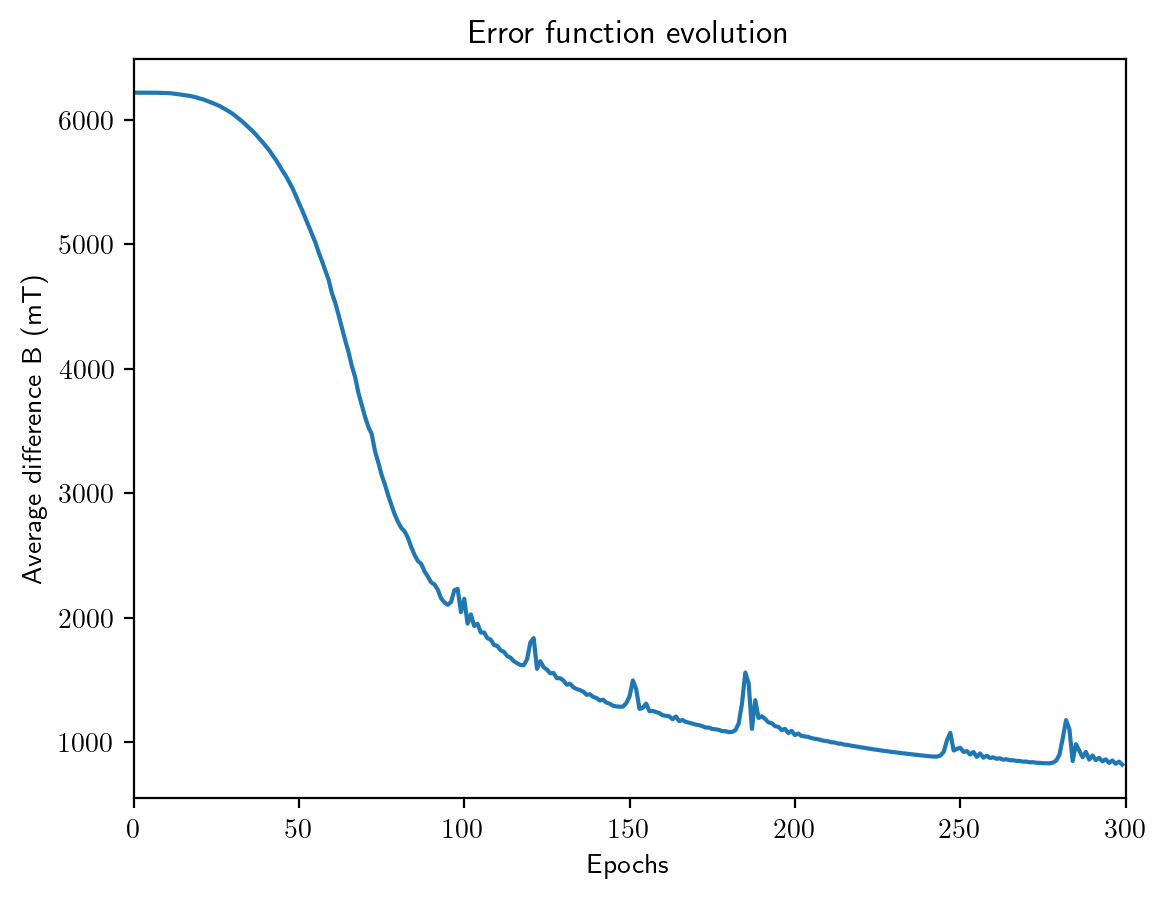

In [35]:
# Perform the fit using the NN
FittingMethod_withmask.fit(n_epochs=300)
# Plot the exvolution of the loss function
FittingMethod_withmask.plot_loss()

Removed the padding that was applied to the data


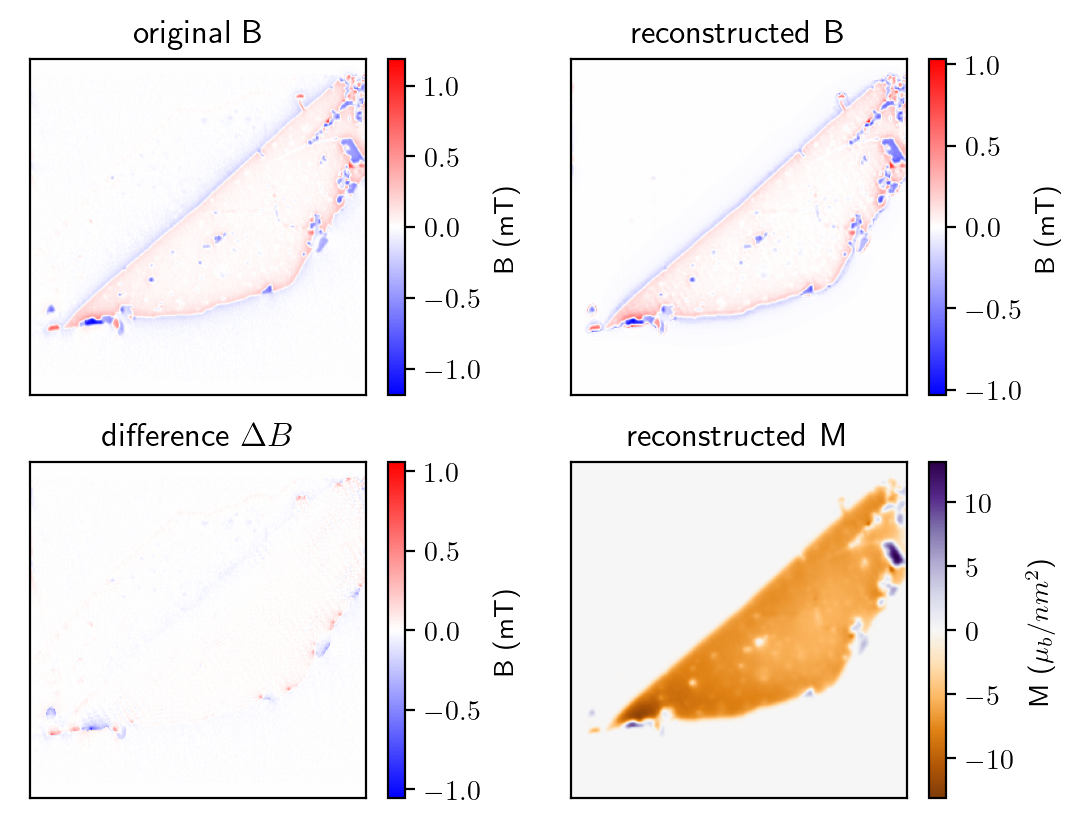

In [36]:
# Plot the results of the reconstruction
FittingMethod_withmask.plot_results()

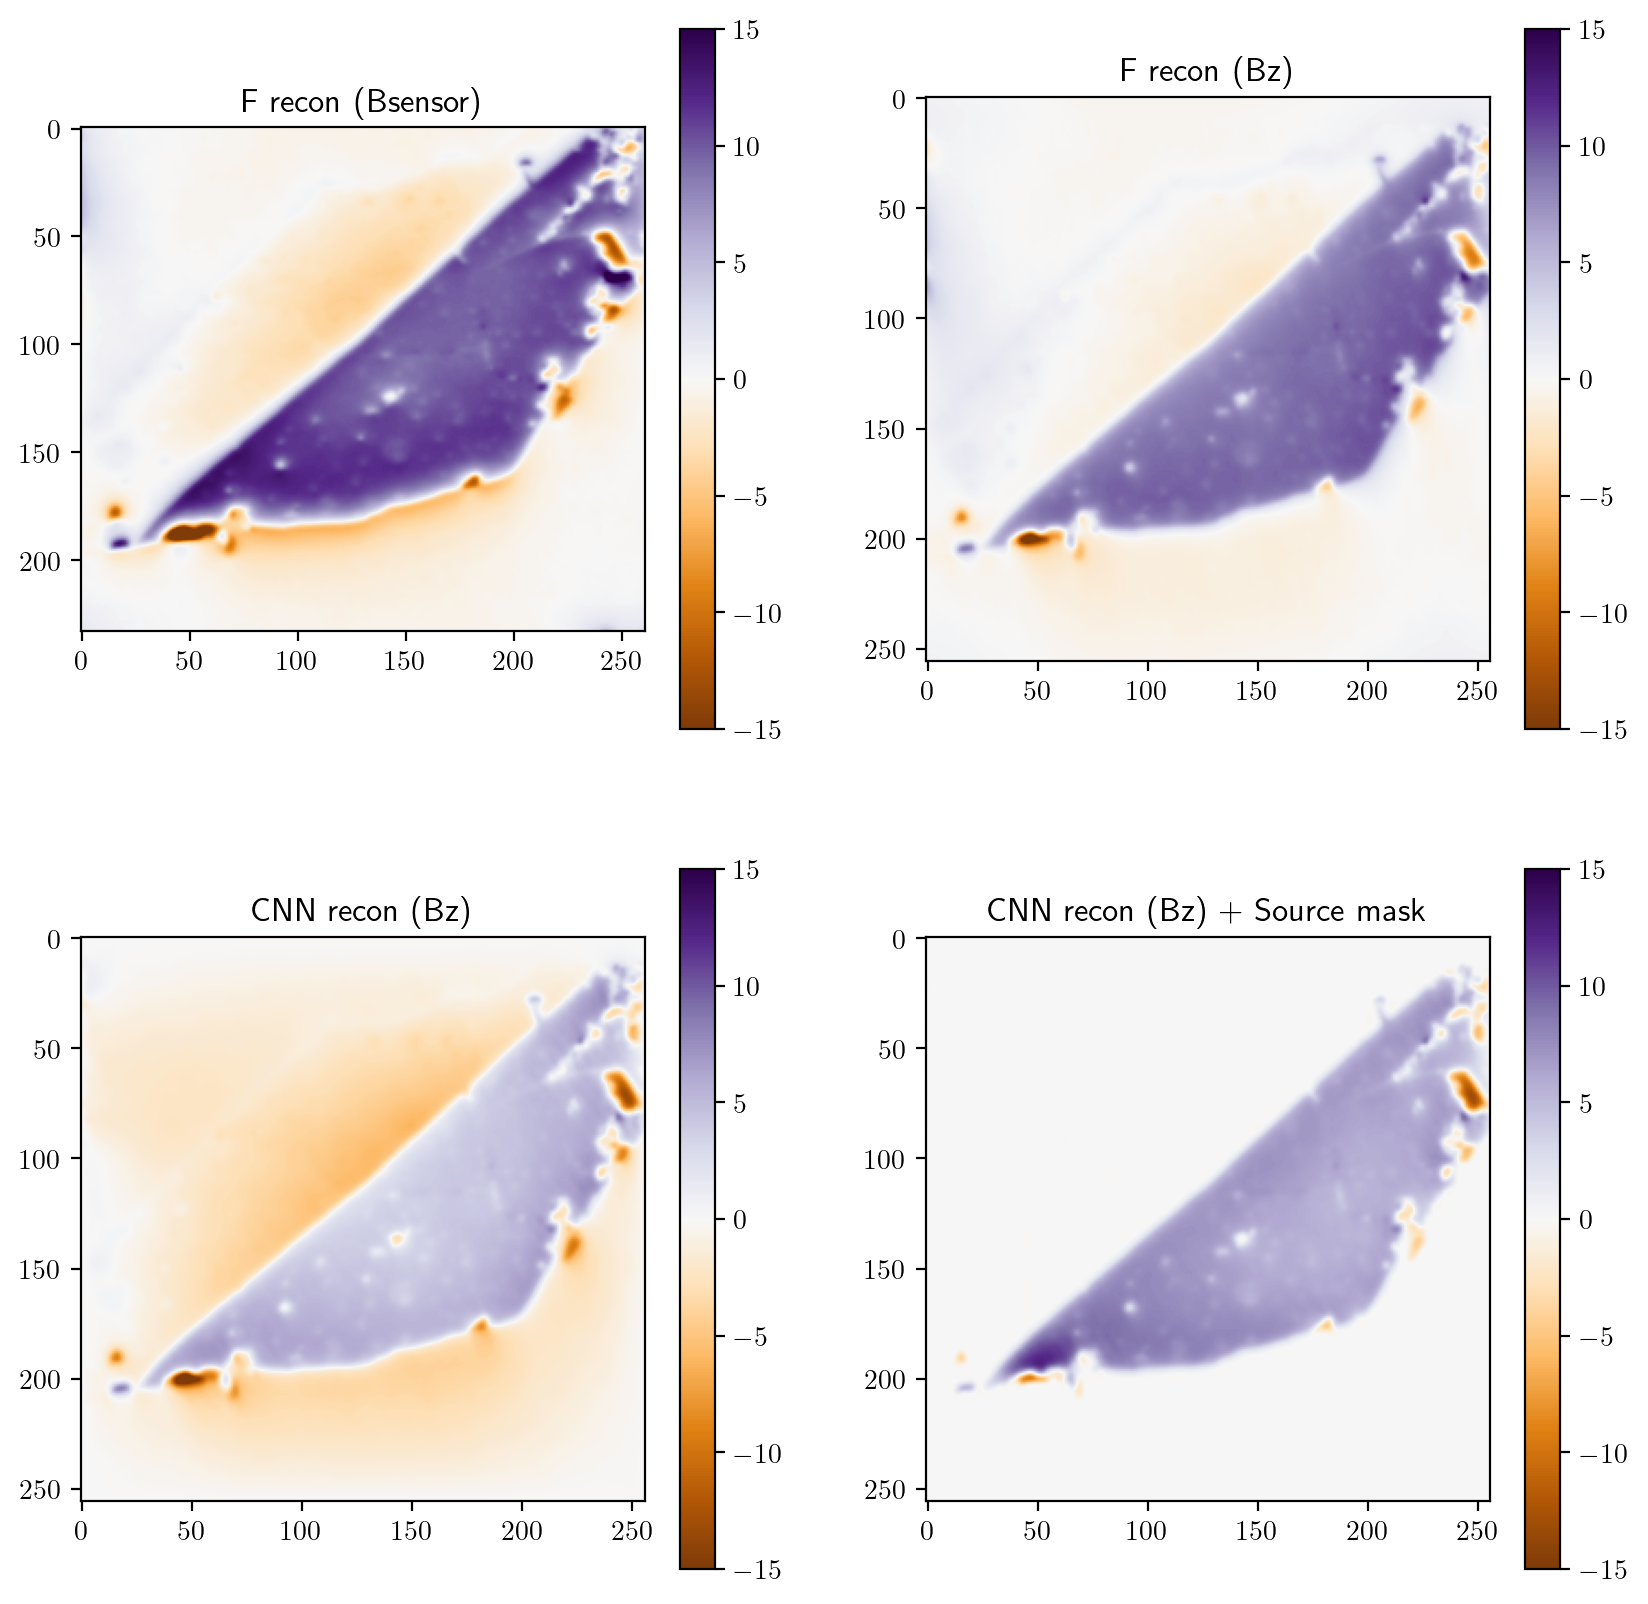

In [40]:
# Sompare the results of all the different reconstructions

plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
plt.imshow(-1*Frecon_dataset.transformed_target + 2, cmap="PuOr", vmin=-15, vmax = 15)
plt.title("F recon (Bsensor)")
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(-1*Frecon_bz_dataset.transformed_target + 2, cmap="PuOr", vmin=-15, vmax = 15)
plt.title("F recon (Bz)")
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(-1*FittingMethod.results["Magnetisation"] , cmap="PuOr", vmin=-15, vmax = 15)
plt.title("CNN recon (Bz)")
plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(-1*FittingMethod_withmask.results["Magnetisation"] , cmap="PuOr", vmin=-15, vmax = 15)
plt.title("CNN recon (Bz) + Source mask")
plt.colorbar()
